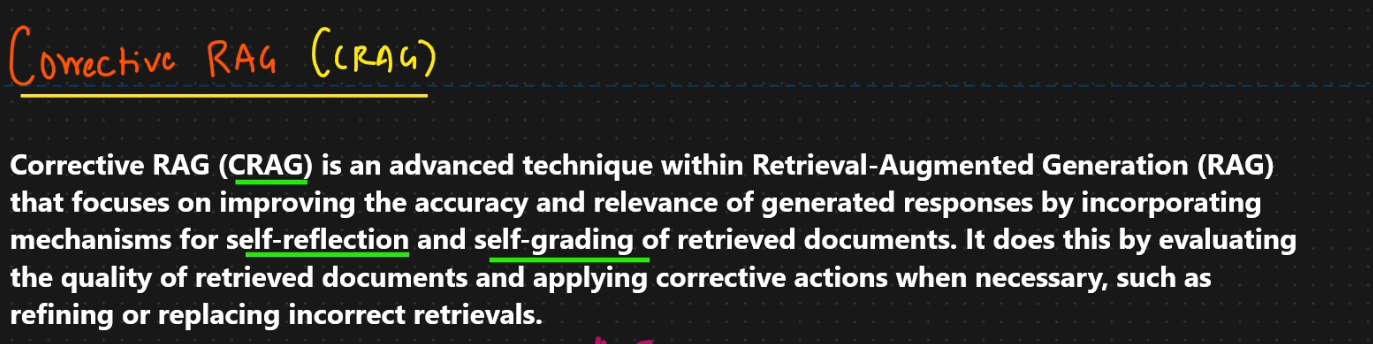

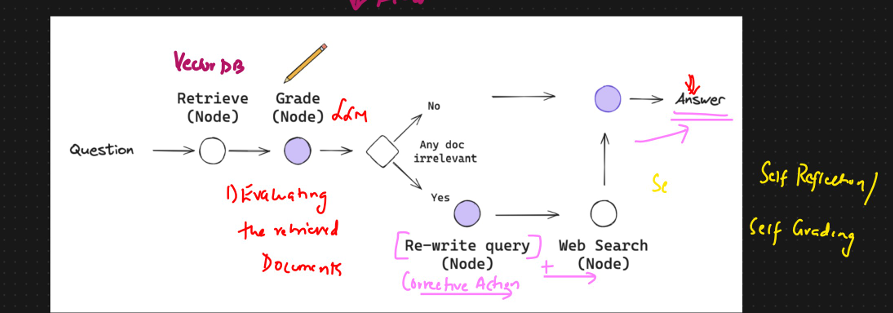

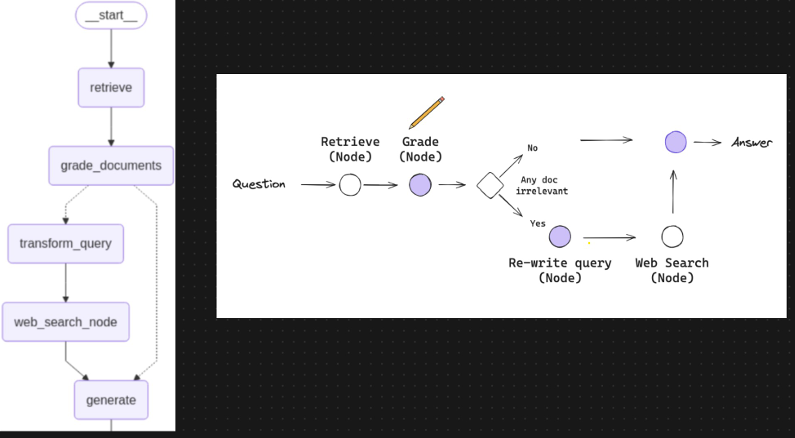

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()



True

In [2]:
from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user just said "Hello". I need to respond appropriately. Let me think about the right way to reply. Since it\'s a greeting, I should acknowledge it and offer assistance. Maybe say something like "Hello! How can I assist you today?" That\'s friendly and opens the door for them to ask for help. I should keep it simple and welcoming. No need for any complex language. Just a straightforward, positive response.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 9, 'total_tokens': 114, 'completion_time': 0.204411988, 'prompt_time': 0.000303556, 'queue_time': 0.053641174, 'total_time': 0.204715544}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--85281b34-20c3-4957-a37a-4c422f5235f6-0', usage_metadata={'input_tokens': 9, 'output_tokens': 105, 'total_tok

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# 4. Embed and Save to FAISS
# Load your API key from the .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv("Google_API_KEY")
# ========================
embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)


# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embd
)


retriever=vectorstore.as_retriever()

In [6]:
retriever.invoke("What is an agent?")

[Document(id='0c20dd55-4890-43b7-b01a-2016057ea4c7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [7]:
## Grade documenr node 
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field

class Grader(BaseModel):
    "binary classification of the document it give yes if relevant of document and no if not relevant"
    binary_score: str = Field(description="binary score of the document, yes or no")



llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader=llm.with_structured_output(Grader)



# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [12]:
## Generate a response
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt =hub.pull("rlm/rag-prompt")

llm = ChatGroq(model="qwen/qwen3-32b")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

<think>
Okay, let's tackle the question about agent memory. The user wants to know how memory works in LLM-powered autonomous agents. Let me look through the provided documents.

First, the context mentions that agents have both short-term and long-term memory. Short-term is like in-context learning, using the model's current context window. That's limited by the Transformer's context length. Then there's long-term memory, which uses external vector stores for infinite retention and fast retrieval. They also talk about using tools and APIs to access external info.

Wait, the documents also compare human memory types—sensory, short-term, long-term. For agents, sensory is raw input embeddings, short-term is in-context learning, and long-term is external storage. They mention techniques like Maximum Inner Product Search (MIPS) with ANN algorithms for efficient retrieval. 

So the answer should explain short-term (in-context, limited) and long-term (external storage, vector databases). Nee

In [13]:
#if the document is not relevant, we can use the grader to rewrite the input to give  a proper response

llm = ChatGroq(model="qwen/qwen3-32b")

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'<think>\nOkay, the user provided the initial question "agent memory" and wants an improved version for web search. Let me start by understanding what they\'re asking. "Agent memory" is pretty vague. Maybe they\'re referring to how AI agents store and use memory? Or perhaps it\'s about agents in a different context, like software agents or even human agents in a role-playing scenario.\n\nFirst, I need to consider the possible contexts. In AI, agent memory could relate to machine learning models retaining information between interactions, which is crucial for maintaining context in conversations. The user might be looking for information on types of memory (like episodic, semantic) used in AI agents or how memory is implemented technically (like using databases, neural networks).\n\nAnother angle is if they\'re referring to memory mechanisms in multi-agent systems, where multiple agents interact and share information. Maybe the question is about the challenges in managing memory for age

In [14]:
# websearch
tavily_key = os.getenv("TAVILY_API_KEY")
if tavily_key is None:
    print("Error: TAVILY_API_KEY not found in environment variables")
else:
    os.environ["TAVILY_API_KEY"] = tavily_key

In [15]:

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\User\AppData\Local\Temp\ipykernel_16668\1309628264.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [17]:
web_search_tool.invoke("What is the latest research on quantum computing?")

[{'title': 'World Quantum Day 2025: Groundbreaking advancements from ...',
  'url': 'https://pme.uchicago.edu/news/world-quantum-day-2025-groundbreaking-advancements-chicagos-quantum-ecosystem',
  'content': 'Learn more about some of the latest quantum research and announcements coming from the UChicago Pritzker School of Molecular Engineering and its partners below.\n\nNew technique paves way for hybrid quantum networks\n\nNetworking quantum computers together to scale up their potential computing power poses a difficult challenge. [...] The University of Chicago Department of Computer Science is at the forefront of turning this promise into a reality. A groundbreaking new study that was presented at this year’s Quantum Information Processing Conference, the most prestigious conference on the theory of quantum computation, delves into the heart of quantum circuits, uncovering secrets about their behavior that could propel us closer to this transformative future.\n\n—Learn about the pa

In [18]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [20]:
#MAKE  A function of retrriver ,gender ,rewrite_question, web_search_tool,generate_final_response
from langchain.schema import Document



def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


In [21]:
def generate(state):
    """
    Generate a response based on the retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the generated response
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation, "question": question}


In [ ]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION (GRADE) ---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [23]:
def transform_query(state):
    """
    Transforms the question to be more suitable for web search.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, transformed_question, that contains the transformed question
    """
    print("---TRANSFORM QUESTION---")
    question = state["question"]
    transformed_question = question_rewriter.invoke({"question": question})
    return {"transformed_question": transformed_question, "question": question}

In [24]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

In [25]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [26]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()


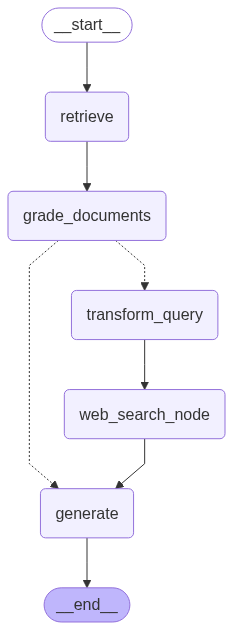

In [27]:
app

In [28]:
app.invoke({"question":"What are the types of agent memory?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUESTION---
---WEB SEARCH---
---GENERATE---


{'question': 'What are the types of agent memory?',
 'generation': "<think>\nOkay, the user is asking about the types of agent memory. Let me look at the provided documents.\n\nFirst, the first document mentions short-term memory as in-context learning, limited by the context window. Long-term memory uses external vector stores for retrieval. There's also sensory memory for raw inputs.\n\nThe second document seems similar, but the page content is more about the structure of the blog post. The third document adds more details, categorizing memory into short-term (context window, working memory) and long-term (factual, episodic, procedural). It also mentions multi-modal memory and ethical considerations. \n\nWait, the user wants the main types. The key ones are short-term and long-term. Under short-term, there's working memory. Long-term includes factual, episodic, and procedural. Also, the first document mentions sensory memory. But the third document's table lists working, factual, epi

In [29]:
app.invoke({"question":"What is the braches of chemistry?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUESTION---
---WEB SEARCH---
---GENERATE---


{'question': 'What is the braches of chemistry?',
 'generation': "<think>\nOkay, the user is asking about the branches of chemistry. Let me look through the provided context. The document mentions five main branches: organic, inorganic, analytical, physical, and biochemistry. There's also a mention of other branches like environmental, forensic, and bioanalytical chemistry under analytical. The ACS lists six areas including chemical engineering, but the main five are consistently highlighted. Need to present the primary branches first and note that there are sub-branches. Keep it concise, three sentences max. Make sure to list the main five and mention some sub-branches as examples. Avoid any markdown and use simple language.\n</think>\n\nThe five main branches of chemistry are organic chemistry, inorganic chemistry, analytical chemistry, physical chemistry, and biochemistry. Each branch focuses on different aspects, such as carbon-based compounds (organic), non-carbon substances (inor

In [30]:
app.invoke({"question":"explain the basic prompting ?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUESTION---
---WEB SEARCH---
---GENERATE---


{'question': 'explain the basic prompting ?',
 'generation': "<think>\nOkay, the user is asking to explain basic prompting. Let me look at the provided context.\n\nFirst, the documents mention that prompt engineering, or in-context prompting, is about steering an LLM's behavior without updating its weights. The basic methods are zero-shot and few-shot learning. Zero-shot is when you just ask the model to perform a task without examples. Few-shot provides a few examples of input-output pairs to guide the model, which usually gives better results but uses more tokens. The context also notes that few-shot can be resource-intensive and might hit context length limits. \n\nSo, the answer should cover zero-shot and few-shot, their differences in approach, effectiveness, and resource usage. Keep it concise, three sentences max. Don't include advanced techniques like chain-of-thought unless necessary. Make sure to mention that basic prompting focuses on these two methods and their trade-offs.\

In [32]:
app.invoke({"question": "what is prompt Engineering  ?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUESTION---
---WEB SEARCH---
---GENERATE---


{'question': 'what is prompt Engineering  ?',
 'generation': '<think>\nOkay, let\'s tackle this question: "What is prompt engineering?" The user provided several documents, all from the same source, Lilian Weng\'s blog post from March 2023. \n\nFirst, I need to parse the context. The main points from the documents mention that prompt engineering, also called In-Context Prompting, involves methods to communicate with LLMs (Large Language Models) to steer their behavior without updating model weights. It\'s described as an empirical science with varying effectiveness across models, requiring experimentation and heuristics. The focus is on autoregressive models, not Cloze tests or multimodal models. The goal is alignment and model steerability.\n\nAnother part of the context from a different document (probably the same post) talks about basic prompting techniques like zero-shot and few-shot learning. Zero-shot is giving the task directly, while few-shot provides examples. There\'s also me

In [33]:
app.invoke({"question": "what is Agent  ?"})

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---


{'question': 'what is Agent  ?',
 'generation': '<think>\nOkay, I need to answer the question "what is Agent?" using the provided context. Let me start by reading through the context documents to understand the key points.\n\nThe context documents are all about LLM-powered autonomous agents. They mention that agents use a large language model (LLM) as their core controller. The components include planning, memory (both short-term and long-term), and tool use. Planning involves breaking down tasks into subgoals and self-reflection. Memory uses in-context learning for short-term and external storage for long-term. Tool use allows agents to access external APIs for information they don\'t have in their model weights.\n\nThe answer should define an agent in this context. I should mention the LLM as the brain, the key components (planning, memory, tools), and maybe give examples like AutoGPT. Keep it concise, three sentences max. Let me make sure I don\'t include any challenges or specific 

# 🔧 Problem with Basic RAG (In Detail)

**RAG** stands for **Retrieval-Augmented Generation**.  
It works in two steps:

### 🧭 1. Retrieve  
The system searches a knowledge base (like documents, PDFs, or web pages) to find information related to the question.

### ✍️ 2. Generate  
The system gives that information to a language model (like GPT), which uses it to create an answer.

---

## ❌ The Problem with Basic RAG

Basic RAG **completely trusts** the documents it retrieves.  
So if the retrieved data is:

- ❌ Outdated  
- ❌ Incomplete  
- ❌ Incorrect  
- ❌ Not relevant to the question

Then the **final answer** will also be **wrong or misleading**,  
even if the language model is very powerful.

---

# ⚙️ What CRAG Does (Super Simple)

**CRAG** stands for **Corrective Retrieval-Augmented Generation**.  
It improves RAG by **checking and fixing** the retrieved info before giving the final answer.

---

## 🧠 1. Retrieval Evaluator

- It **checks the quality** of the information found.
- It asks:
  - Is this information **good**?
  - Is it **correct and useful**?
- If not, it marks it to be **fixed later**.

---

## ✍️ 2. Generative Model

- It **writes the first answer** using the retrieved information.
- If the input information is bad, the answer might be **wrong or weak**.

---

## 🔧 3. Refinement and Correction

- It **improves or fixes** the initial answer.
- It can:
  - 🔍 Search again for **better information**
  - ✅ **Correct mistakes**
  - 🧹 Make the answer **clearer and more accurate**

---

# ✅ Benefits of CRAG

### 🎯 1. More Accurate Answers
- CRAG **doesn't just accept** information — it **checks and fixes** it.
- This means **fewer mistakes** and **better answers**.

---

### 🔍 2. More Relevant Answers
- CRAG removes **useless or unrelated** content.
- The final answer is **focused and useful**.

---

### 🛡️ 3. More Reliable System
- Even if the first retrieval is **poor**, CRAG can still **recover**.
- It can **fix or replace bad data** to create a high-quality answer.

---
